In [1]:

# Set up notebook
%pprint
import sys
if (osp.join(os.pardir, 'py') not in sys.path): sys.path.insert(1, osp.join(os.pardir, 'py'))

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import (fu, nu, DataFrame, to_datetime, Series, concat, np, osp)
from datetime import date, timedelta
import os
from IPython.display import HTML
import pandas as pd


# Create Swap Measure ANOVA Dataframe


To do formal comparisons we need to run statistics like ANOVA and t-tests. We'll need the values for each measure per responder. Something like this below:
<table>
    <tr><th>ID</th><th>Group</th><th>TTS</th><th>THC</th><th>THCP</th><th>Tag Accuracy</th></tr>
    <tr><td>Responder 1</td><td>EM Resident</td><td>8:20</td><td>6:10</td><td>25</td><td>81</td></tr>
    <tr><td>Responder 2</td><td>EMT-Basic</td><td>8:05</td><td>5:02</td><td>15</td><td>75</td></tr>
    <tr><td>Responder 3</td><td>Paramedic</td><td>7:40</td><td>4:30</td><td>18</td><td>78</td></tr>
</table>
etc. For the "Other" label, instead, put back whether they were Faculty or something else (Nurse I believe).

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='',
    first_responder_master_registry_scene_stats_df='',
    count_swaps_df='', first11_optimal_order_df='',
    verbose=False
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 401177 332 111
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 332 332 19
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 486 332 48
count_swaps_df = data_frames_dict['count_swaps_df']
print('count_swaps_df', count_swaps_df.shape[0], count_swaps_df.session_uuid.nunique(), count_swaps_df.shape[1]) # 331 331 3
first11_optimal_order_df = data_frames_dict['first11_optimal_order_df']
print('first11_optimal_order_df', first11_optimal_order_df.shape) # (11, 7)

triage_paper_df 401177 332 111
file_stats_df 332 332 19
scene_stats_df 486 332 48
count_swaps_df 331 331 3
first11_optimal_order_df (12, 7)


In [4]:

# Merge only count swaps scenes
patient_count_filter_fn = lambda scene_df: True
elevens_df = fu.get_elevens_dataframe(
    triage_paper_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner'),
    file_stats_df,
    scene_stats_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner'),
    needed_columns=[
        'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'overall_category',
        'encounter_layout'
    ],
    patient_count_filter_fn=patient_count_filter_fn
)
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 397230 331 118

elevens_df 397230 331 119


In [5]:

# Get a dataset of only first11 patients
nongrouped_patients_list = nu.load_object('nongrouped_patients_list')
mask_series = ~elevens_df.patient_id.isin(nongrouped_patients_list)
elevens_df = elevens_df[mask_series]
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 388745 331 118

elevens_df 390108 331 119


In [6]:

# Get a dataset of only "First 11" encounter layouts
mask_series = (elevens_df.encounter_layout == 'DCEMS 11')
display(elevens_df.groupby('encounter_layout').size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))
elevens_df = elevens_df[~mask_series]
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 388745 331 118

,record_count
encounter_layout,
First 11,366742
DCEMS 11,23083


elevens_df 367025 295 119


In [7]:

# for the "Other" label, instead, put back whether they were Faculty or something else (Nurse, etc.)
mask_series = (elevens_df.responder_category == 'Other')
elevens_df.loc[mask_series, 'responder_category'] = elevens_df.loc[mask_series, 'overall_category']

In [8]:

# Get priority group dictionary and set a column with in the merge dataset
mask_series = ~first11_optimal_order_df.Patient.isnull()
priority_group_dict = first11_optimal_order_df[mask_series].set_index('Patient').Group.to_dict()

mask_series = ~first11_optimal_order_df.Patient.isnull()
first11_patients_list = sorted(first11_optimal_order_df[mask_series].Patient.unique())
print(priority_group_dict)
mask_series = elevens_df.patient_id.isin(first11_patients_list)
elevens_df.loc[mask_series, 'priority_group'] = elevens_df.loc[mask_series, 'patient_id'].map(priority_group_dict)

{'Gary_3 Root': 1, 'Lily_2 Root': 1, 'Bob_0 Root': 1, 'Gary_1 Root': 1, 'Mike_5 Root': 1, 'Lily_4 Root': 1, 'Mike_7 Root': 1, 'Gloria_6 Root': 2, 'Bob_9 Root': 3, 'Gloria_8 Root': 3, 'Helga_10 Root': 3, 'Gary_9 Root': 3}



## Triage efficiency (mean, SD, median, IQR) by each responder type


* **Time to triage scene**

In [9]:

# Get info for Time to triage scene
from datetime import timedelta

cn = 'triage_time'
statistics_df = DataFrame([])
temporalize_fn = lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='minutes')
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    df = Series(
        [fu.get_triage_time(scene_df) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
    ).to_frame().rename(columns={0: cn})
    df = nu.get_statistics(df, [cn]).applymap(temporalize_fn, na_action='ignore')
    statistics_df = concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
    ttts_dict = df.to_dict()[cn]
    print(
        f"{responder_category}: {ttts_dict['mean']} (SD = {ttts_dict['SD']}, Median = {ttts_dict['median']},"
        f" IQR = ({ttts_dict['25%']}, {ttts_dict['75%']}))"
    )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Mean Time to Triage Scene', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: 8:34 (SD = 1:45, Median = 8:22, IQR = (7:34, 9:07))
EM-Faculty: 10:40 (SD = 4:12, Median = 9:53, IQR = (7:16, 13:18))
EMT-Basic: 8:18 (SD = 2:17, Median = 7:38, IQR = (6:47, 9:36))
Medical Student: 8:40 (SD = 2:13, Median = 8:46, IQR = (7:28, 10:12))
Nurse: 7:24 (SD = nan, Median = 7:24, IQR = (7:24, 7:24))
Other HP: 8:23 (SD = nan, Median = 8:23, IQR = (8:23, 8:23))
Paramedic: 7:24 (SD = 1:47, Median = 7:09, IQR = (6:07, 8:16))



,Mean Time to Triage Scene,SD,Median,IQR
EM Resident,8:34,1:45,8:22,"(7:34, 9:07)"
EM-Faculty,10:40,4:12,9:53,"(7:16, 13:18)"
EMT-Basic,8:18,2:17,7:38,"(6:47, 9:36)"
Medical Student,8:40,2:13,8:46,"(7:28, 10:12)"
Nurse,7:24,NaN,7:24,"(7:24, 7:24)"
Other HP,8:23,NaN,8:23,"(8:23, 8:23)"
Paramedic,7:24,1:47,7:09,"(6:07, 8:16)"



* **Hemorrhage Control for all Life-threatening Bleeding (and percentage of participants who implemented all required hemorrhage control)**

In [10]:

# Get info for Hemorrhage control for all life-threatening bleeding percentage
cn = 'last_controlled_time'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    df = Series(
        [fu.get_time_to_last_hemorrhage_controlled(scene_df) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
    ).to_frame().rename(columns={0: cn})
    df = nu.get_statistics(df, [cn]).applymap(
        lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore'
    )
    hcfaltb_dict = df.to_dict()[cn]
    df = df.rename(columns={cn: responder_category}).T
    phc = int(Series(
        [fu.get_percent_hemorrhage_controlled(scene_df, verbose=False) for _, scene_df in responder_categories_df.groupby(
            fu.scene_groupby_columns
        )]
    ).mean())
    df['phc'] = phc
    statistics_df = concat([statistics_df, df], axis='index')
    print(
        f"{responder_category}: {hcfaltb_dict['mean']} at {phc}% (SD = {hcfaltb_dict['SD']}, Median = {hcfaltb_dict['median']},"
        f" IQR = ({hcfaltb_dict['25%']}, {hcfaltb_dict['75%']}))"
    )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Mean Time to Hemorrhage Control', '%', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[3], 'phc':  columns_list[1]})[columns_list].to_html())

EM Resident: 6:43 at 86% (SD = 1:50, Median = 6:33, IQR = (5:22, 7:31))
EM-Faculty: 8:12 at 100% (SD = 3:41, Median = 8:00, IQR = (5:24, 10:48))
EMT-Basic: 5:03 at 95% (SD = 2:17, Median = 4:14, IQR = (3:55, 5:16))
Medical Student: 5:34 at 84% (SD = 2:34, Median = 5:46, IQR = (4:32, 7:16))
Nurse: 3:55 at 100% (SD = nan, Median = 3:55, IQR = (3:55, 3:55))
Other HP: 6:43 at 100% (SD = nan, Median = 6:43, IQR = (6:43, 6:43))
Paramedic: 5:04 at 96% (SD = 1:35, Median = 4:52, IQR = (4:03, 5:48))



,Mean Time to Hemorrhage Control,%,SD,Median,IQR
EM Resident,6:43,86,1:50,6:33,"(5:22, 7:31)"
EM-Faculty,8:12,100,3:41,8:00,"(5:24, 10:48)"
EMT-Basic,5:03,95,2:17,4:14,"(3:55, 5:16)"
Medical Student,5:34,84,2:34,5:46,"(4:32, 7:16)"
Nurse,3:55,100,NaN,3:55,"(3:55, 3:55)"
Other HP,6:43,100,NaN,6:43,"(6:43, 6:43)"
Paramedic,5:04,96,1:35,4:52,"(4:03, 5:48)"



* **Hemorrhage Control per Patient**

In [11]:

# Get info for Hemorrhage control per patient
# Duration of time from when the patient was first approached by the participant until
# the time hemorrhage treatment was applied (with a tourniquet or wound packing)
cn = 'controlled_time'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    times_list = []
    for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns):
        for _, patient_df in scene_df.groupby('patient_id'):
            if fu.get_is_patient_hemorrhaging(patient_df):
                controlled_time = fu.get_time_to_hemorrhage_control(patient_df, scene_start=fu.get_first_patient_interaction(patient_df))
                times_list.append(controlled_time)
    df = Series(times_list).to_frame().rename(columns={0: cn})
    df = nu.get_statistics(df, [cn]).applymap(lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='seconds'), na_action='ignore')
    statistics_df = concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
    hcpp_dict = df.to_dict()[cn]
    print(
        f"{responder_category}: {hcpp_dict['mean']} (SD = {hcpp_dict['SD']}, Median = {hcpp_dict['median']},"
        f" IQR = ({hcpp_dict['25%']}, {hcpp_dict['75%']}))"
    )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Time for Hemorrhage control for each Patient', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: 39 sec (SD = 1:17, Median = 12 sec, IQR = (3 sec, 31 sec))
EM-Faculty: 38 sec (SD = 1:06, Median = 14 sec, IQR = (8 sec, 25 sec))
EMT-Basic: 10 sec (SD = 15 sec, Median = 7 sec, IQR = (2 sec, 13 sec))
Medical Student: 37 sec (SD = 1:17, Median = 11 sec, IQR = (4 sec, 23 sec))
Nurse: 11 sec (SD = 8 sec, Median = 10 sec, IQR = (8 sec, 13 sec))
Other HP: 11 sec (SD = 11 sec, Median = 5 sec, IQR = (4 sec, 21 sec))
Paramedic: 15 sec (SD = 34 sec, Median = 8 sec, IQR = (2 sec, 14 sec))



,Time for Hemorrhage control for each Patient,SD,Median,IQR
EM Resident,39 sec,1:17,12 sec,"(3 sec, 31 sec)"
EM-Faculty,38 sec,1:06,14 sec,"(8 sec, 25 sec)"
EMT-Basic,10 sec,15 sec,7 sec,"(2 sec, 13 sec)"
Medical Student,37 sec,1:17,11 sec,"(4 sec, 23 sec)"
Nurse,11 sec,8 sec,10 sec,"(8 sec, 13 sec)"
Other HP,11 sec,11 sec,5 sec,"(4 sec, 21 sec)"
Paramedic,15 sec,34 sec,8 sec,"(2 sec, 14 sec)"



## Triage accuracy (mean, SD, median, IQR) by each responder type (to keep things simple let's not break this out by individual tag category as we had it, but by overall rates for each responder type)

In [ ]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_dataframe(elevens_df, groupby_column='responder_category')

In [29]:

df = tag_to_salt_df.groupby(fu.scene_groupby_columns).sum()
mask_series = (df.patient_count != 11)
df[mask_series]

,,patient_count,is_tag_correct
session_uuid,scene_id,,
8d30008e-c05a-4b2d-8b1c-2e0857985912,0,1,0
c598ce3a-f613-4d50-8a2f-96cfab35de1c,0,1,1
d8e74818-ecc1-4f24-87aa-5dd9facfe20f,0,1,0
fa155795-d519-45a5-89a4-0ee8c4ea756d,0,1,0


In [ ]:

# Get the percentage tag correct counts for each scene for each group
correct_count_by_tag_df = fu.get_percentage_tag_correct_dataframe(tag_to_salt_df, groupby_column='responder_category')

In [31]:

df = correct_count_by_tag_df.groupby(fu.scene_groupby_columns).sum()
mask_series = (df.total_count != 11)
df[mask_series]

,,correct_count,total_count,percentage_tag_correct
session_uuid,scene_id,,,
8d30008e-c05a-4b2d-8b1c-2e0857985912,0,0,1,0.0
c598ce3a-f613-4d50-8a2f-96cfab35de1c,0,1,1,100.0
d8e74818-ecc1-4f24-87aa-5dd9facfe20f,0,0,1,0.0
fa155795-d519-45a5-89a4-0ee8c4ea756d,0,0,1,0.0


In [32]:

df = correct_count_by_tag_df.groupby(fu.scene_groupby_columns).mean()
mask_series = (df.percentage_tag_correct == 0.0)
display(df[mask_series])

,,correct_count,total_count,percentage_tag_correct
session_uuid,scene_id,,,
8d30008e-c05a-4b2d-8b1c-2e0857985912,0,0.0,1.0,0.0
ccfb5502-64b5-4d1c-9ca3-63f522330041,0,0.0,11.0,0.0
d8e74818-ecc1-4f24-87aa-5dd9facfe20f,0,0.0,1.0,0.0
fa155795-d519-45a5-89a4-0ee8c4ea756d,0,0.0,1.0,0.0



* **triage tag accuracy**

In [14]:

# Get info for triage tag accuracy
cn = 'percentage_tag_correct'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in correct_count_by_tag_df.groupby('responder_category'):
    mask_series = responder_categories_df.predicted_tag.isin(fu.tag_color_order[:-1])
    df = responder_categories_df[mask_series]
    df = nu.get_statistics(df, [cn])
    statistics_df = concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
    tta_dict = df.to_dict()[cn]
    print(
        f"{responder_category}: accurately tagged {tta_dict['mean']:.1f}% of patients (SD = {tta_dict['SD']:.1f}, Median = {tta_dict['median']},"
        f" IQR = ({tta_dict['25%']:.1f}, {tta_dict['75%']}))"
    )

# Display as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'].map(lambda x: str(round(x, 1))) + ', ' + statistics_df['75%'].map(lambda x: str(x)) + ')'
for cn in ['mean', 'SD']: statistics_df[cn] = statistics_df[cn].map(lambda x: str(round(x, 1)))
columns_list = ['Mean % Accurately Tagged', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: accurately tagged 75.6% of patients (SD = 35.2, Median = 100.0, IQR = (50.0, 100.0))
EM-Faculty: accurately tagged 78.3% of patients (SD = 33.3, Median = 100.0, IQR = (62.5, 100.0))
EMT-Basic: accurately tagged 81.9% of patients (SD = 29.6, Median = 100.0, IQR = (70.8, 100.0))
Medical Student: accurately tagged 72.2% of patients (SD = 37.4, Median = 100.0, IQR = (50.0, 100.0))
Nurse: accurately tagged 90.0% of patients (SD = 22.4, Median = 100.0, IQR = (100.0, 100.0))
Other HP: accurately tagged 81.7% of patients (SD = 29.1, Median = 100.0, IQR = (75.0, 100.0))
Paramedic: accurately tagged 80.9% of patients (SD = 31.8, Median = 100.0, IQR = (66.7, 100.0))



,Mean % Accurately Tagged,SD,Median,IQR
EM Resident,75.6,35.2,100.0,"(50.0, 100.0)"
EM-Faculty,78.3,33.3,100.0,"(62.5, 100.0)"
EMT-Basic,81.9,29.6,100.0,"(70.8, 100.0)"
Medical Student,72.2,37.4,100.0,"(50.0, 100.0)"
Nurse,90.0,22.4,100.0,"(100.0, 100.0)"
Other HP,81.7,29.1,100.0,"(75.0, 100.0)"
Paramedic,80.9,31.8,100.0,"(66.7, 100.0)"


In [15]:

mask_series = (elevens_df.scene_type == 'Triage') & (elevens_df.is_scene_aborted == False)
gb = elevens_df[mask_series].groupby(['session_uuid', 'responder_category'])
rows_list = []
for i, ((session_uuid, responder_category), session_df) in enumerate(gb):
    largest_tuple = sorted(
        [(scene_df, scene_df.shape[0], scene_id) for scene_id, scene_df in session_df.groupby('scene_id')], key=lambda x: x[1]
    )[-1]
    responder_categories_df = largest_tuple[0]
    row_dict = {'ID': f'Responder {i+1}', 'Group': responder_category, 'session_uuid': session_uuid}
    row_dict['TtTS'] = fu.get_triage_time(responder_categories_df)
    row_dict['TtHC'] = fu.get_time_to_last_hemorrhage_controlled(responder_categories_df)
    
    # Duration of time from when the patient was first approached by the participant until
    # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
    row_dict['MTfHCpP'] = fu.get_time_to_hemorrhage_control_per_patient(responder_categories_df)
    
    scene_id = largest_tuple[2]
    mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
    mask_series &= (correct_count_by_tag_df.responder_category == responder_category)
    if mask_series.any():
        row_dict['MPAT'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
    rows_list.append(row_dict)
swap_measure_anova_df = DataFrame(rows_list)
nu.save_data_frames(swap_measure_anova_df=swap_measure_anova_df)
print(swap_measure_anova_df.shape[0], swap_measure_anova_df.session_uuid.nunique(), swap_measure_anova_df.shape[1]) # 330 330 7

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/swap_measure_anova_df.csv
294 294 7


In [ ]:
raise


----

In [50]:

# Examine the failed tagging scenes
df = correct_count_by_tag_df.groupby(fu.scene_groupby_columns).mean().reset_index(drop=False)
mask_series = (df.percentage_tag_correct == 0.0)
mask_series = file_stats_df.session_uuid.isin(df[mask_series].session_uuid)
print(
    'The files that have 0% correct tagging in one of their scenes are'
    f' {nu.conjunctify_nouns(sorted(file_stats_df[mask_series].session_file_name))}.')
# display(file_stats_df[mask_series].T)
mask_series = (df.percentage_tag_correct == 0.0)
display(df[mask_series].merge(scene_stats_df, on=fu.scene_groupby_columns, how='inner').T)

The files that have 0% correct tagging in one of their scenes are 23.03.14.0807.csv, 23.03.14.0827.csv, 23.03.14.0923.csv, and 23.07.26.1440.csv.


,0,1,2,3
session_uuid,8d30008e-c05a-4b2d-8b1c-2e0857985912,ccfb5502-64b5-4d1c-9ca3-63f522330041,d8e74818-ecc1-4f24-87aa-5dd9facfe20f,fa155795-d519-45a5-89a4-0ee8c4ea756d
scene_id,0,0,0,0
correct_count,0.0,0.0,0.0,0.0
total_count,1.0,11.0,1.0,1.0
percentage_tag_correct,0.0,0.0,0.0,0.0
last_still_engagement,621982.0,NaN,116926.0,192515.0
actual_engagement_distance,45.579994,0.0,41.652764,27.070325
ideal_engagement_distance,30.995272,0.0,30.659312,30.611399
measure_of_ideal_ordering,0.468306,NaN,0.426318,0.686261
distracted_engagement_distance,30.63303,0.0,30.238374,30.117888


In [49]:

# Change the encounter layout to DCEMS 11
session_uuid = 'ccfb5502-64b5-4d1c-9ca3-63f522330041'
scene_id = 0
columns_list = [
    'session_uuid', 'file_name', 'session_file_date', 'session_file_name', 'responder_name', 'responder_type', 'site_name', 'encounter_layout',
    'is_a_one_triage_file', 'is_in_registry', 'overall_category', 'global_category', 'global_description', 'sub_category', 'sub_description',
    'responder_category', 'scene_id', 'adherence_to_salt', 'has_patient_in_agony', 'patient_count', 'cluster_label', 'is_scene_aborted', 'scene_type'
]
file_stats_df[file_stats_df.session_uuid == session_uuid].merge(
    scene_stats_df[(scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)], on=['session_uuid'], how='inner'
)[columns_list].T.sort_index()

,0
adherence_to_salt,False
cluster_label,1
encounter_layout,First 11
file_name,First Responder Master Registry 2.26.2026/23.0...
global_category,EMS
global_description,Emergency Medical Services
has_patient_in_agony,True
is_a_one_triage_file,True
is_in_registry,True
is_scene_aborted,False


In [7]:

# Check out why one of our files is aborted
mask_series = (file_stats_df.encounter_layout == 'DCEMS 11')
uuid_set = set(file_stats_df[~mask_series].session_uuid) - set(elevens_df.session_uuid)
mask_series = file_stats_df.session_uuid.isin(uuid_set)
display(file_stats_df[mask_series].T.sort_index())

mask_series = triage_paper_df.session_uuid.isin(uuid_set)
scene_df = triage_paper_df[mask_series]
scene_start = fu.get_scene_start(scene_df)
last_engagement = fu.get_last_engagement(scene_df)
start_to_last_engagement = last_engagement - scene_start
print(start_to_last_engagement/1000/60)

,168
encounter_layout,First 11
file_name,First Responder Master Registry 2.26.2026/23.0...
file_start_time,2023-03-03 10:23:00
file_stop_time,2023-03-03 10:39:00
global_category,EMS
global_description,Emergency Medical Services
is_a_one_triage_file,True
is_in_registry,True
logger_version,1.0
overall_category,Paramedic


16.5842



Check for the 159 people with the single patient order error. Could you do a count of whether the error is from group 2 or group 3 and/or, if possible, which patient from the group they are treating first (if it's group 2 we know which patient it is cause there is only one patient in group 2, but for group 3 we wouldnt because there are three).

In [10]:

print()
count_swaps_df.swaps_to_perfect_order_count.value_counts().sort_index()

0    109
1    193
2     15
3     12
4      2
Name: swaps_to_perfect_order_count, dtype: int64

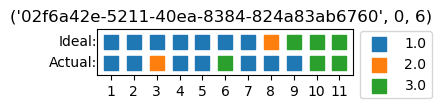

In [12]:

# Check for the 159 people with the single patient order error
mask_series = (count_swaps_df.swaps_to_perfect_order_count == 1)

# Get a count of whether the error is from group 2 or group 3
n = 5  # Number of times to loop
tuples_list = []
for ((session_uuid, scene_id), _), n in zip(count_swaps_df[mask_series].groupby(fu.scene_groupby_columns), range(n)):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
    scene_df = elevens_df[mask_series]
    # print(session_uuid, scene_id, scene_df.shape[0])
    actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_priority_group_sequences(scene_df, verbose=False)
    unsort_dict = {v1: k for k, v in sort_dict.items() for v1 in v}
    actual_list = [unsort_dict[a] for a in actual_sequence]
    ideal_list = [unsort_dict[i] for i in ideal_sequence]
    if len(sort_dict[3]) and (actual_list.index(3) < len(actual_list) - len(sort_dict[3])):
        plt = nu.plot_sequences([actual_list, ideal_list], color_dict={1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'})
        title_obj = plt.suptitle(t=(session_uuid, scene_id, actual_list.index(3)+1), x=0.5, y=1.2)
        plt.annotate('Ideal:', (0.0, 2.0), textcoords='offset points', xytext=(-10, 0), ha='right', va='center')
        plt.annotate('Actual:', (0.0, 2.0), textcoords='offset points', xytext=(-10, -15), ha='right', va='center')
    if len(sort_dict[2]):
        sequence_tuple = (
            session_uuid, scene_id, actual_sequence.tolist().index(sort_dict[2][0])+1,
            actual_list, ideal_list
         )
        tuples_list.append(sequence_tuple)

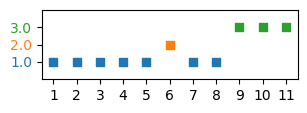

In [13]:

ax = nu.plot_sequence(
    actual_list, highlighted_ngrams=[],
    color_dict={1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'},
    suptitle=None, first_element='SESSION_START', last_element='SESSION_END', alphabet_list=None, verbose=False
)

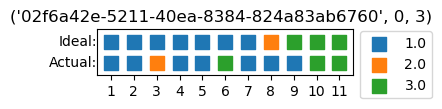

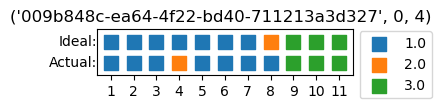

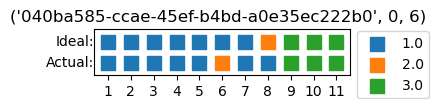

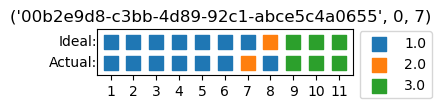

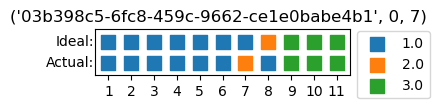

In [14]:

# Show the worst case scenarios
n = 5  # Number of times to loop
for sequence_tuple, n in zip(sorted(tuples_list, key=lambda x: x[2]), range(n)):
    plt = nu.plot_sequences([sequence_tuple[3], sequence_tuple[4]])
    title_obj = plt.suptitle(t=(sequence_tuple[0], sequence_tuple[1], sequence_tuple[2]), x=0.5, y=1.2)
    plt.annotate('Ideal:', (0.0, 2.0), textcoords='offset points', xytext=(-10, 0), ha='right', va='center')
    plt.annotate('Actual:', (0.0, 2.0), textcoords='offset points', xytext=(-10, -15), ha='right', va='center')

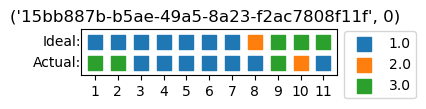

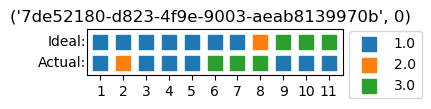

In [15]:

# Check for the people with the patient order errors
mask_series = (count_swaps_df.swaps_to_perfect_order_count == 4)

n = 5  # Number of times to loop
session_uuids_list = []
for ((session_uuid, scene_id), _), n in zip(count_swaps_df[mask_series].groupby(fu.scene_groupby_columns), range(n)):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
    scene_df = elevens_df[mask_series]
    actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_priority_group_sequences(scene_df, verbose=False)
    unsort_dict = {v1: k for k, v in sort_dict.items() for v1 in v}
    actual_list = [unsort_dict[a] for a in actual_sequence]
    ideal_list = [unsort_dict[i] for i in ideal_sequence]
    plt = nu.plot_sequences([actual_list, ideal_list], color_dict={1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'})
    title_obj = plt.suptitle(t=(session_uuid, scene_id), x=0.5, y=1.2)
    plt.annotate('Ideal:', (0.0, 2.0), textcoords='offset points', xytext=(-10, 0), ha='right', va='center')
    plt.annotate('Actual:', (0.0, 2.0), textcoords='offset points', xytext=(-10, -15), ha='right', va='center')
    session_uuids_list.append(session_uuid)

In [4]:

# Find out who gets lost
anova_xlsx_session_uuids = [
    '009b848c-ea64-4f22-bd40-711213a3d327', '00b2e9d8-c3bb-4d89-92c1-abce5c4a0655', '02f6a42e-5211-40ea-8384-824a83ab6760', '03b398c5-6fc8-459c-9662-ce1e0babe4b1',
    '040ba585-ccae-45ef-b4bd-a0e35ec222b0', '04882754-51a0-4e5b-9617-b200e3609116', '04acc8f2-1e64-47b2-9606-8d661f584aec', '054918a7-9634-40fe-8356-2ce0c9cc376f',
    '06303b89-128e-4bfb-9e6f-a843da3134f9', '0667e56a-abe6-4097-9a56-33735f4855e2', '0786a1df-d010-4b1b-a99a-e00df486d479', '09024025-1320-4891-aefa-a497744ed3e2',
    '0940a9be-3ff5-4739-b04b-a7605c1ffa2f', '09f30ce2-1507-4ef1-84f1-3dfb3e6d9b86', '0b01cf49-87cc-4647-9f29-b8dff39dcd6c', '0b1d6253-9c4f-43b7-8217-6f0e486aabe7',
    '0b41cfdc-0891-4d1d-91ea-ac86fa54a34c', '0bfe46ef-6644-441e-a903-5445f2ee4fd5', '0d3e0c62-db52-40f9-9ee8-7fc84a1dcbf2', '0fa439d6-476c-49a5-b478-48e3454974e1',
    '0fb12cf8-dcf5-4110-b090-3b3271e9add6', '1044049f-c7e0-4a16-98d3-e3826b4b8bfc', '1046b7d9-5848-41b5-9438-cf0dc4dc6cbe', '1344120d-5834-4bbf-8f60-383a8752b512',
    '13839608-6085-4a88-a8f2-74af9fd06a05', '13862ebb-4616-4d09-a725-c34661b6fa9c', '14678e1f-aa1c-4a67-a31f-65dd3e2238ca', '14a344df-eee2-4fd1-b182-e3cdacd9026c',
    '14f8e67c-bdc3-4c9c-9603-70cd51eb2367', '1507bc88-8d4c-4c1c-9291-210f790c96e3', '1563e213-aaa4-4b79-84a1-8f917ea9f7a9', '15bb887b-b5ae-49a5-8a23-f2ac7808f11f',
    '16359508-f91b-4f85-baeb-dade7d574a61', '16373b36-886a-4d0d-9015-474d29d139cc', '1663640c-5a60-4fa6-8bf4-249f41a693a5', '17962d45-8e90-4b50-86e7-77451042aac8',
    '17b80e0f-9afe-497f-b3a3-0549c14a4ba9', '1813599d-cfde-45f0-8555-428b57478ebb', '18bfbc11-3c60-4c89-94cc-ac8fea028318', '18e1dec6-b780-4e77-a6b9-f608f2483e53',
    '1cfebb9a-6000-4742-81be-6103ebe168bc', '1df10bfd-0f85-42ff-a873-36dfe05df77b', '1e7d274d-f393-4888-9f28-4de53b0260e3', '1fb559e8-15c6-463a-bda8-79ca0bfc330f',
    '20168f93-040c-4290-aa7e-2b197825c9de', '206da802-d38f-4f3a-98e3-44f99481479d', '20e5782a-d6f7-4361-a590-7e710c176765', '2107820d-d55c-40bb-bb90-6b10c227664c',
    '21577c78-0085-4962-a363-b88526e3c212', '21b0f09b-03b4-4af8-ac65-11ab1e5458d8', '2270eaba-f9b5-4f96-8a5e-b69276846474', '22e2c9a3-b93f-4f7f-896a-ca188c78505b',
    '24205a11-9e21-44b7-a565-985454c90776', '251a4532-ff1f-4182-91ce-4215786a339a', '25309ebf-8ca2-4678-af43-2d4030eb1c5d', '25de35e0-354f-4785-9738-31c44e37fcbc',
    '26cf9b5b-3395-49f1-a3e5-7fefd22b3a6b', '26f08763-076e-4531-a6f7-f00232f664bd', '27c2fa44-ba05-417c-ae95-317b06870dc9', '2930a371-1187-4b98-adfc-19e095637e48',
    '2aeb2057-cbe2-494c-98a5-fc2bdbef1355', '2afd4e87-ac2a-4738-9e46-3b19d3385a32', '2bc11b9d-374b-4ab7-9d87-967931962fe8', '2c981992-899d-46b1-b92c-d086e21118db',
    '2d26ca7b-1dbb-42e4-9bbf-bf0d131e2e06', '2d511693-6144-45ee-89df-aba0ca629c84', '2d920452-cfa3-41f4-95de-36b62a023900', '2df4352b-22b9-4a9f-9c2c-6031978251e1',
    '2e8678fd-fdc4-40c2-8122-09f1e31b8d2a', '30a49dd8-c08a-4994-a622-57647670b5bb', '30d6a023-e0a3-4678-9ef2-6011964d225a', '313259a4-162f-44f6-8479-92e4554a1464',
    '31d9c549-d016-4e44-8262-1d51b7adde29', '321db911-0ed9-421a-9219-bb02038ac660', '3228f729-d512-431a-bb96-d6f9aacb5d00', '331f875e-eba1-4033-a502-6a888aee4e9c',
    '33b51683-fa6a-4dd3-82e5-de08bcc17c14', '33e7d6b6-2868-42e6-8967-d6890efb87a7', '33f3d2d4-49b4-43cf-80d4-cd7d5993aca4', '3435501b-192a-457f-9763-7985f7975784',
    '3459b742-650d-4c82-bb7b-db84a843cc66', '34bef815-47b3-4977-91f7-3bb68803387a', '36ebe99c-dcda-4677-945c-cb05f312d61c', '37daf3d7-4288-4954-a0bd-ca6872cf1e82',
    '37db3752-51c8-463f-94a5-2196b6854cf6', '37ed31fb-6f8a-4cc0-b80e-ac4138e42405', '38b995b3-fb77-4fda-b0b4-21f062ed6a38', '3bac8365-232a-4be0-a551-c5214b9f0706',
    '3ce991bc-a2d1-46fd-a3a4-d3611e946ed7', '3e4e23e4-ce9e-44b7-9a1e-6e2923b33123', '3f142e7e-1e18-4341-947a-71f2e7f35aa2', '400b6351-6f35-4f5b-98a6-db100a2fefd8',
    '401ce554-b556-4a10-88bb-424ed5c22ea8', '40efaf29-70b3-435a-8847-bcd4235720be', '41f05171-141a-4df6-9d89-334331310c9b', '4219eddf-b044-43ad-9e01-c0333fc428c5',
    '4226ad6c-bb0a-4df0-8c4a-64c312927578', '43313faf-6031-4433-be70-d5d828f55cff', '44458d4a-3cce-4907-85e3-3db1375ce6bb', '445ceb23-1514-4490-9aa6-f2fc55b5d28e',
    '45118b95-412c-4a2d-9373-8f7da3428ca8', '46c273a6-b8be-46ea-96cd-72903780d43d', '48c426ae-e88c-49bd-8010-37dc7b042c95', '48e95cfe-1dd7-4085-9662-c77827980bdd',
    '496ff2bf-605d-4654-b945-dc2b0aaea626', '4a504e80-0232-4978-9a63-7e503e86c5e3', '4bac0722-bc76-4418-88f0-ccbbba469c5a', '4ca5febe-0a4b-4c77-bd3e-6632ae760df1',
    '4ce8ee9f-45ea-42a8-86df-0038c777f040', '4f66ee10-3104-44ec-8d31-9e1c2b33f36d', '50e4351a-3afd-43ff-a65f-f84eaab0d0fd', '51f8d40c-9550-4ef1-a71c-e030c0a08f29',
    '524d5418-62f4-4834-9f1e-47202c30e667', '52e2653e-2230-4d8a-929b-e2a12dcb56c4', '55dcba1c-2bfc-4028-984d-5c288c8b7265', '56c0b2ce-d12c-440a-bcae-3d6163d5e494',
    '578a0cfc-a256-4002-ba75-4a61d700204e', '590bdfe9-828c-4367-a783-75ec19d7b7d0', '5aca0157-02d0-4409-a4fe-f64d03fd34a1', '5c5c9f6e-555c-4ae2-a0c0-7e5eb84a92dd',
    '5c720560-85f5-4bb1-9aa5-41207f6259a2', '5c8b0274-379c-40ca-b6ff-b846f9e14ad5', '5d916938-e0d3-47ee-8f55-12bf12283ee1', '5dce5abe-7ded-46e7-8d07-b2e2cd76ef55',
    '5de8dcc6-c6ab-43e5-9103-85c8d069cf4b', '5e1e1072-2244-4473-996d-e2cb337b805b', '5ebf3067-e1a6-4711-810d-60095452c24c', '5ffacacb-a874-43d3-a399-3cb959505047',
    '6037b1d3-eff2-4317-9372-768236fbae91', '60d2041e-9b37-4c13-a73d-906e6ecebd01', '60d42fe6-f30b-4eab-ba01-644dde714e4d', '61dba1bb-2326-48f9-968f-9e0e4c867eee',
    '61dd1584-76e8-4536-9aeb-15276e646ff4', '62c1d3c9-f9ab-4475-81e4-ccbbaa166c9e', '634a2340-066c-4993-a7be-a7ff0481b6b0', '638950ca-b008-4b14-bd07-933e16e7d8e0',
    '63b272d4-ae7c-4cc3-8e5b-d474b09a44c2', '66cc58aa-8f53-4d06-b129-879fb3b08239', '6774cf2a-7728-4387-8788-934246a1e906', '677d1c18-f292-4bcb-924d-52f5e762533f',
    '67ed9702-0908-454a-8069-7ca4a6f2bee9', '6816890d-3882-41a2-ac2a-e6c4171d2da2', '684d04c4-83c1-49b6-b798-ddd431438857', '68f0ccd0-ecbc-4b90-b5d1-83d9517995b8',
    '6909d3b6-a43a-4d26-8c83-9bd8a5ea569f', '6925e2d8-3f2b-443d-8e59-7bac6684464d', '693461dd-b8f6-4c60-92b6-bd1db0ffcac8', '6b704e43-9ef4-4d5c-b39b-40c41648f8d3',
    '6cb3d605-3736-4255-bf3b-92473d9df21e', '6cc2fd2a-88a9-4ffa-9230-cfab1f206fce', '6d681ea4-2632-4ede-a5d6-6e493c5ebd53', '6e3a5d8b-12c4-4afd-9a2e-619eb5b72b23',
    '6f1a94ad-99cb-49a6-86f8-145e6c090fae', '716087c9-37c5-43b8-93ab-18339caefcd2', '71a7d2ce-2dea-4bec-8348-028e74fcd092', '72388f54-3a93-445e-b5fa-4a71640965fb',
    '736e625b-bb07-452c-9302-b37bb27cbf43', '73df0a9b-795b-41e2-97a0-6079fb7ca739', '7407aba4-aef4-4012-be6c-a237d225809d', '741e494b-63ff-4ea2-ad88-657f2276045d',
    '75865699-63f9-46de-9adc-6936ad7c7d46', '75b3227f-2f3c-4fe0-b9b8-9e0fe3baa210', '77c15654-dbf5-46da-8e84-fe418cdf1c59', '788af03e-aeee-4d53-8c97-f0060df61932',
    '79426650-c950-40ee-816e-decddddd22e9', '7a1065f6-1a05-4d2b-bf14-73cafdb9ce4b', '7dacebd5-f16e-4faa-8a00-f738b7d04e3b', '7de52180-d823-4f9e-9003-aeab8139970b',
    '7e340eb0-fda8-4eea-addc-5f554be907a5', '7f639dc1-fce0-4aa9-b76a-c355894d05ed', '7fcfbc5e-d5d2-431a-98ab-c3d9375e934e', '81d7c616-7896-4e0a-9cfc-155590686377',
    '836b793c-3094-49ae-b614-3e9c9ff7e330', '83b96c70-e156-4c10-b463-800c5a468ec5', '84282ed0-0e63-44e0-8b39-5156e3c868d0', '84f8db6a-1993-493f-b6cb-609ac3b45107',
    '8581c1f8-a4e8-4245-ac73-2bd671237001', '86366fd5-be94-43cc-a9e9-7c98609c0a66', '868cbf3b-f04a-4e1a-a207-95881d529378', '868d644f-b0fa-4ef7-b29e-88bac6fb5740',
    '86c4cdb2-0073-43fb-b60a-dc13fa46a9ca', '87efcdf5-9090-4fa5-afac-25c778924e9a', '8832990e-c81c-45c4-96d5-3ca57a75cbe6', '888de8e3-f293-4564-bc6a-9c1214f5064b',
    '89c48e7e-780f-4f1b-a846-fc0f4fd9841c', '89ec8f32-0018-48e7-8cad-c86bd73257f2', '89f0e2ad-384b-4ef0-ab96-d865521f88ce', '8b5e760a-1f1a-4a28-bd8f-768bc5f216c6',
    '8ceb28a3-e268-4930-a1c6-84cac4f6239c', '8d30008e-c05a-4b2d-8b1c-2e0857985912', '8f0e76c0-6ff2-4974-b0f7-3f416e22fa90', '8f6097ce-795d-483a-a811-e6a5423bc59d',
    '9179223d-a6e0-4612-8200-40f30d05c11e', '926de73a-7764-4409-920e-b2416cb57f9b', '93b9eeb6-e902-4466-a518-a992c61146f8', '97401484-055e-4590-9a11-7d911c42564b',
    '983344e9-c2d0-46b5-a8ba-da6e37d04f1d', '98bad4ce-f31e-40f1-898e-ed38755e0340', '991af001-9414-4a2d-8079-0663c4ddb1e4', '992d4672-7993-44ba-890c-0d8605ccefdd',
    '9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13', '9a7ff4ee-e75c-490d-86d7-b917c066f9c1', '9cd41444-4813-45a8-81d0-a1d068184c8e', '9d142377-69d6-4622-958d-a29a6a0a0d21',
    '9e0f8037-329b-496a-817a-daae83aa941f', '9f03c005-21d8-4934-8bb9-7152347726d1', '9fac5a9d-0f55-4473-9744-f7100561354f', 'a118a19a-0126-48ea-9d7b-7762f8e99926',
    'a1cb9dd5-e62b-4085-99d8-688e0a3856ee', 'a275e363-d113-4f29-873c-a312f732ae0d', 'a3113d56-505e-40c1-8c39-09baacc82efa', 'a40659ab-dfbf-43ab-91cb-72a48a82c426',
    'a437d61b-adad-424f-9714-83382548fda2', 'a62cdd57-739f-4f98-b0bd-45e7aced8b73', 'a6470837-fcab-4478-bdbf-c27bdc3960ef', 'a7804ee3-6a1c-4462-957a-17976a540483',
    'a9804531-1ed7-4b97-b3c1-96784faf5228', 'a98adcc8-6df3-470d-961d-8248246472ca', 'a98b7327-dfd7-43c2-86e7-b5080ec86806', 'ab1f8cd1-8d65-45da-b087-89b25ff46c66',
    'aca8a746-0f72-4c8d-87a5-70d836da8768', 'ad39e17f-169a-4062-95af-cd6f194cdace', 'af2f4603-a819-4d08-bc09-db30a910fc3f', 'af8ec7e7-e34b-472d-98ea-2a78285c8de8',
    'b05e5139-6dd4-41d2-adb5-aedfebb028a6', 'b0a0d36e-4fb8-43b7-a966-d730e1130945', 'b0ff9d39-598b-46b3-b3bc-1be3a791f10c', 'b1ebfdc9-6338-4b80-ba76-947f8690bd91',
    'b2276063-07ef-40b9-8764-bfb5e064699c', 'b26d61b8-9027-4b16-ba3b-bc337bc6e681', 'b3f3b351-c82b-47ef-81b5-0bce3be917f3', 'b440a9ce-e511-43e3-bc20-c9b2bed11005',
    'b52e71ec-050f-49e1-b495-7c36f5537544', 'b541f5c9-93fe-4ef3-9fe7-38493b8aa8a8', 'b5a82a5b-e259-4d87-bdb7-94f9cb1ce6ea', 'b792d8cf-a314-47ba-8da6-6998a8d735c2',
    'b878d528-37a0-4175-a294-16c4de1fd5eb', 'b97662b0-aa86-4317-adae-7bce0e065eb5', 'b97bfac8-c52a-4019-8494-1e9ae36df7cf', 'bd13e705-6cf0-4adc-a628-c605c4ae6a3e',
    'c090fff8-5f81-40c5-b313-5fb7ce42ab9f', 'c12f8355-5a14-4ccc-bde4-d8038cae9220', 'c51a263e-fca1-4d93-929a-2c644cc441c6', 'c598ce3a-f613-4d50-8a2f-96cfab35de1c',
    'c74476ed-d5ee-4318-86e0-fefebe5e32ee', 'c7587083-faff-4bca-b678-ae156bd4a3f0', 'c82e4612-4e6f-4834-bc7f-6092327c44fa', 'c993d63e-166e-45fa-9cb3-07908a234428',
    'caeb519a-ca9f-45c5-a28b-2c2977194a6a', 'cc319a3d-a27d-44a2-a594-ff5cecd9ee9a', 'cc6ad812-608f-4fc3-bae6-f837aaa056c0', 'ccfb5502-64b5-4d1c-9ca3-63f522330041',
    'ccfca520-5965-40d9-9a19-f0a19d208fdc', 'cdc7b0ec-a883-4705-9b55-b618d429808e', 'cde3b77f-2e08-4b86-9081-d0faa979cbc8', 'ce1350af-79e6-475b-9c07-802b5ff5ca0a',
    'ce41d7c3-9e24-4840-865f-3b7f7cd828f7', 'cf714cd2-2824-4ad2-8d98-3199b1df0bdb', 'cf953248-e6cf-4544-95ce-4843d0f56f10', 'd06f4054-097a-46ef-a88e-69665bf42389',
    'd0e616ae-5458-42c9-a013-55b8f3b51b06', 'd11543fd-7b7f-4883-bd69-afe8128a76f2', 'd1445846-942b-422f-86ae-8b2a0b6133a8', 'd2c676e2-fddc-4872-9a26-b621d6585df9',
    'd347b967-5e20-4527-95dd-3a0fdf73af1d', 'd433b532-d35b-4fc6-b9fd-ed2e18e57c28', 'd45ac4ce-be32-424b-a50f-fa8007af4fed', 'd4f8b28e-a0a3-4969-a156-5bf86e4794ba',
    'd58c859d-d4b5-4213-88d7-df5c168fa646', 'd605640c-fde5-412f-8d33-b9b2744172ab', 'd66b46ee-9057-43d6-8108-179b83820a37', 'd81f6dfd-3151-415f-a354-541240e7fbae',
    'd8c6bf18-14e3-45f2-bfa1-9a904cb4b82b', 'd8e74818-ecc1-4f24-87aa-5dd9facfe20f', 'd8fe95a5-c1fb-4239-8b42-12d28c35e111', 'daca96a3-b61d-4087-9747-cea6fd7e3a43',
    'dcd4a197-ba73-4d2f-a2aa-8ff3206219b9', 'dd46bfb4-d2df-4b1c-923f-5f3568a14f29', 'dd601aee-8360-41f2-b89d-c37f3eb2c617', 'de04bec3-9503-467c-9c49-675720c4bab0',
    'de327503-2f08-4562-9543-547cbabd52e1', 'dee5a112-91db-43bb-8564-dc4ce4195a88', 'deecd930-56c6-4679-87d8-7d6627631934', 'dfa09c43-42f4-4cb5-8f74-381744e0d320',
    'e072d31f-2592-4c7e-8709-3db1e111240c', 'e0b7bea0-1cf9-42a8-a02c-e8699a962779', 'e1a418bf-114d-4b8e-b0a1-0a0ff144c0aa', 'e1d845d3-9874-449b-83ef-6c649073a868',
    'e2458ea2-71b5-4b84-bbfb-dff0a969c9d2', 'e249e6d4-c3d4-4e20-8fab-fa35fd59e871', 'e2ddf563-3583-404c-917a-8eb7bec38471', 'e2e599c8-8e48-487f-9f95-a0a382432ca5',
    'e353eee2-a630-40cd-b931-a98b12edd9b6', 'e3c2b4c6-d8b7-4b64-8cd0-7ca0e622f9b5', 'e4b17764-a999-4733-b455-1968588effc8', 'e77c15e0-d0de-413d-a471-20a285e81387',
    'e7ea73c9-dc1c-47cc-bb13-996b4069c73e', 'e8be80d7-4d11-430d-93b7-bc15e1bfb445', 'e8cb6ae0-6d68-410f-88fc-4adf30d8bfac', 'e96d123b-455b-4335-9278-988ff9ba8ecf',
    'ea7d43f6-a7ed-4bc7-8002-f056ee415082', 'eb641af4-13da-4e13-a5dd-02eb0e7e6c23', 'ec6c5444-8f8b-417d-a840-f1173d3a0296', 'ed079161-e1ea-4682-9abb-d0b1736e3ee5',
    'ee42b183-00b2-4bb9-89b9-0b38b73e69eb', 'ee694b2c-dad2-4b9a-acc9-4e025e1b299b', 'ee8a8276-1a9c-41fd-a793-a3eb6d337ff7', 'eecb1d19-1d05-4725-9289-eb02d601cdf3',
    'efed5e1c-4427-47df-8e3f-9e4714880169', 'f02dc87e-8f04-4ddd-90fd-74dce1206bd6', 'f0a4acff-b70a-4577-a27e-df492cb9638d', 'f1b2887d-8ed3-499e-8663-0fb9bd909fbc',
    'f2eb6809-d49f-4c3e-be62-91f1538ed437', 'f3228193-b6dc-41fa-a2ab-1c5085046347', 'f33f702d-4b79-43d9-b980-42dc10c2b882', 'f3447210-99fa-4990-8c1b-747a1e916e79',
    'f3cbb8a9-8d0c-48f0-ac0c-e379ac4d9411', 'f5dafd5d-461d-4440-9e3b-1b1c899df9e4', 'f68ce2b4-67dc-4829-89fc-cfe478391148', 'f7d9738a-35c1-4af0-8e98-5bf3a1cff310',
    'f807c3e2-6cc7-4670-8488-4dd13431cc15', 'f80ef1e8-e0d1-4106-9f18-4024ff911e22', 'f9b3d74c-634d-40fc-9183-4c4bad4e7548', 'fa155795-d519-45a5-89a4-0ee8c4ea756d',
    'fd1c7057-2c2d-4dec-9297-92ef0621c15e', 'fdb4a6d9-72ef-4af7-bdd4-a05ba354a300', 'fe077b96-8e52-4e1a-8ec7-e5c5f46e65c5', 'fe2602f0-e9e8-4913-8bf3-806852ce738a',
    'ff97fc56-c803-4aa7-b419-35e0ac17d0b3', 'ffecd29f-ebcd-45d2-9bc1-12adf56cfff8'
]
mask_series = ~count_swaps_df.session_uuid.isin(anova_xlsx_session_uuids)
df = count_swaps_df[mask_series]
if 'file_name' in df.columns: df.file_name = df.file_name.map(lambda x: x.replace('/', '/ '))
print()
HTML(df.T.to_html())

,170
session_uuid,7e75d331-2643-4271-a67e-af24bff68001
scene_id,0
swaps_to_perfect_order_count,0
